## Illustration of simultaneous Electrocorticography (ECoG) and LFP measurements.
* https://github.com/LFPy/LFPy/blob/master/examples/example_ECoG.py

### Description
* This is an example scripts using LFPy with a passive cell model adapted from
Mainen and Sejnowski, Nature 1996, for the original files, see
https://modeldb.science/download/2488

* Illustration of simultaneous Electrocorticography (ECoG) and LFP measurements.
The same cell and input is used as in example_7.py (07_Active_cell_models),
The LFP is calculated either assuming an infinite homogeneous medium,
or with taking into account the boundary between the cortex and the
medium that is covers the cortex. In addition the ECoG signal is
calculated at the top of the brain, with a large recording electrode,
which introduces strong spatial averaging.


```
Copyright (C) 2017 Computational Neuroscience Group, NMBU.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
```

In [1]:
# importing some modules, setting some matplotlib values for pl.plot.
import LFPy
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
plt.rcParams.update({'font.size': 12,
                     'figure.facecolor': '1',
                     'figure.subplot.wspace': 0.5,
                     'figure.subplot.hspace': 0.5})

# seed for random generation
np.random.seed(1234)

--No graphics will be displayed.


In [2]:

def plot_LFP_and_ECoG(cell, electrode, electrode_MoI, ecog_electrode):

    ecog_clr = "darkgreen"
    cortex_clr = "salmon"
    surface_clr = "lightblue"

    def elec_clr(idx):
        return plt.cm.rainbow(1.0 * idx / (len(electrode.x)))

    fig = plt.figure(figsize=[16, 8])

    xlim = np.max([ecog_electrode.r, np.abs(cell.x).max()]) + 50

    # plot the morphology, electrode contacts, synapses cortical surface etc.
    ax = fig.add_axes([0.01, 0.08, 0.3, 0.9],
                      frameon=False, aspect=1, xlim=[-xlim, xlim],
                      ylim=[cell.somapos[2] - 250, top_of_cortex + 200])

    zips = []
    for x, z in cell.get_idx_polygons(projection=('x', 'z')):
        zips.append(list(zip(x, z)))
    polycol = PolyCollection(zips,
                             edgecolors='k',
                             facecolors='k')
    ax.add_collection(polycol)
    for i in range(len(cell.synapses)):
        l, = ax.plot([cell.synapses[i].x], [cell.synapses[i].z], '.', c='r')
    for i in range(electrode.x.size):
        l2, = ax.plot(electrode.x[i], electrode.z[i], 'o',
                      color=elec_clr(i), ms=15, clip_on=False)

    # Plot ECoG electrode
    from matplotlib.patches import Ellipse
    el = Ellipse((ecog_electrode.x[0], ecog_electrode.z[0]),
                 2 * ecog_electrode.r, 50, edgecolor='k',
                 facecolor=ecog_clr, clip_on=False)
    ax.add_artist(el)
    ax.text(-ecog_electrode.r, ecog_electrode.z[0] + 50,
            r"ECoG electrode (R = {} $\mu$m)".format(ecog_electrode.r),
            color=ecog_clr)

    ax.text(xlim, top_of_cortex + 100,
            r"$\sigma_S=$" + "\n{} S/m".format(electrode_MoI.sigma_S),
            rotation=-90, color=surface_clr, va='center')

    ax.text(xlim, top_of_cortex - 150,
            r"$\sigma_T=$" + "\n{} S/m".format(electrode_MoI.sigma_T),
            rotation=-90, color=cortex_clr, va="center")

    ax.axhspan(top_of_cortex, top_of_cortex + 200,
               clip_on=False, facecolor=surface_clr, zorder=-2)

    ax.axhspan(cell.z.min() - 200, top_of_cortex,
               clip_on=True, facecolor=cortex_clr, zorder=-2)

    ax.plot([-xlim, xlim + 50], [top_of_cortex, top_of_cortex],
            clip_on=False, ls="--", c='gray', zorder=-1)
    ax.text(xlim + 70, top_of_cortex, "Cortical\nsurface",
            color="gray", va="center")

    ax.legend([l, l2, el], ["Synapse", "LFP electrode", "ECoG electrode"],
              frameon=False, bbox_to_anchor=[0.5, -0.005])

    ax.set_xticks([])
    ax.set_yticks([])

    # plot the somatic trace
    ax = fig.add_axes([0.72, 0.22, 0.25, 0.22],
                      title="Somatic membrane\npotential")
    ax.plot(cell.tvec, cell.somav, 'k')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('mV')

    for loc, spine in ax.spines.items():
        if loc in ['right', 'top']:
            spine.set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # plot the laminar LFP
    ax = fig.add_axes([0.4, 0.08, 0.25, 0.75], frameon=False, yticks=[],
                      ylim=[cell.somapos[2] - 250, cell.z.max() + 50])

    dz = electrode.z[1] - electrode.z[0]
    for i in range(electrode.x.size):

        ax.plot(cell.tvec,
                electrode.data[i] * 0.5 * dz / np.max(np.abs(electrode.data[i])
                                                      )
                + electrode.z[i],
                c="gray", lw=2)
        ax.plot(cell.tvec,
                electrode_MoI.data[i] * 0.5 * dz
                / np.max(np.abs(electrode.data[i])) + electrode.z[i],
                c='k', lw=2, ls="--")
        ax.plot(-10, electrode.z[i],
                color=elec_clr(i), marker='o', ms=15, clip_on=False)

    ax.axis(ax.axis('tight'))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Normalized\nLaminar LFP')

    # plot the ECoG
    ax = fig.add_axes([0.4, 0.9, 0.25, 0.07], frameon=False, yticks=[])

    for i in range(ecog_electrode.x.size):
        ax.plot(cell.tvec,
                ecog_electrode.data[i] / np.max(np.abs(ecog_electrode.data[i])
                                                ),
                c=ecog_clr, lw=2)

    ax.axis(ax.axis('tight'))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Normalized\nECoG')

    # Compare top electode LFP and ECoG
    ax = fig.add_axes([0.72, 0.6, 0.25, 0.3],
                      title="Comparison of ECoG and\ntop electrode LFP")

    l1, = ax.plot(cell.tvec, 1000 * electrode.data[-1], c="gray", lw=2)
    l3, = ax.plot(cell.tvec, 1000 *
                  ecog_electrode.data[-1], c=ecog_clr, ls="-", lw=2)
    l2, = ax.plot(cell.tvec, 1000 *
                  electrode_MoI.data[-1], c="k", ls="--", lw=2)

    fig.legend([l1, l2, l3], ["LFP (infinite homogeneous)",
                              "LFP (cortical surface included)", "ECoG"],
               frameon=False, loc="lower right")
    ax.axis(ax.axis('tight'))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel(r'$\mu$V')
    for loc, spine in ax.spines.items():
        if loc in ['right', 'top']:
            spine.set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    return fig

In [3]:

def insert_synapses(synparams, section, n, spTimesFun, args):
    '''find n compartments to insert synapses onto'''
    idx = cell.get_rand_idx_area_norm(section=section, nidx=n)

    # Insert synapses in an iterative fashion
    for i in idx:
        synparams.update({'idx': int(i)})

        # Some input spike train using the function call
        [spiketimes] = spTimesFun(**args)

        # Create synapse(s) and setting times using the Synapse class in LFPy
        s = LFPy.Synapse(cell, **synparams)
        s.set_spike_times(spiketimes)

In [4]:

##########################################################################
# Define parameters, using dictionaries
# It is possible to set a few more parameters for each class or functions, but
# we chose to show only the most important ones here.
##########################################################################


# define cell parameters used as input to cell-class
cellParameters = {
    'morphology': 'morphologies/L5_Mainen96_wAxon_LFPy.hoc',
    'cm': 1.0,                 # membrane capacitance
    'Ra': 150,                 # axial resistance
    'v_init': -65,             # initial crossmembrane potential
    'passive': True,           # switch on passive mechs
    # passive params
    'passive_parameters': {'g_pas': 1. / 30000, 'e_pas': -65},
    'nsegs_method': 'lambda_f',  # method for setting number of segments,
    'lambda_f': 100,           # segments are isopotential at this frequency
    'dt': 2**-4,               # dt of LFP and NEURON simulation.
    'tstart': -100,  # start time, recorders start at t=0
    'tstop': 200,  # stop time of simulation
}

In [5]:
# Initialize cell instance, using the LFPy.Cell class
cell = LFPy.Cell(**cellParameters)
cell.set_rotation(x=4.98919, y=-4.33261, z=0.)

top_of_cortex = 0

In [6]:
# We place top of cell 50 um below the cortical surface
cell.set_pos(z=top_of_cortex - cell.z.max() - 50)

In [7]:

# Cell bottom needs to be above bottom layer because of convention in
# calculation of ECoG potentials using the Method of Images in
# class RecMEAElectrode. This means that the middle layer
# must extend deeper than the cell.
h = - cell.z.min() + 1

In [8]:

# Synaptic parameters taken from Hendrickson et al 2011
# Excitatory synapse parameters:
synapseParameters_AMPA = {
    'e': 0,  # reversal potential
    'syntype': 'Exp2Syn',  # conductance based exponential synapse
    'tau1': 1.,  # Time constant, rise
    'tau2': 3.,  # Time constant, decay
    'weight': 0.005,  # Synaptic weight
    'record_current': True,  # record synaptic currents
}
# Excitatory synapse parameters
synapseParameters_NMDA = {
    'e': 0,
    'syntype': 'Exp2Syn',
    'tau1': 10.,
    'tau2': 30.,
    'weight': 0.005,
    'record_current': True,
}
# Inhibitory synapse parameters
synapseParameters_GABA_A = {
    'e': -80,
    'syntype': 'Exp2Syn',
    'tau1': 1.,
    'tau2': 12.,
    'weight': 0.005,
    'record_current': True
}

In [9]:
# where to insert, how many, and which input statistics
insert_synapses_AMPA_args = {
    'section': 'apic',
    'n': 100,
    'spTimesFun': LFPy.inputgenerators.get_activation_times_from_distribution,
    'args': dict(n=1,
                 tstart=cellParameters['tstart'],
                 tstop=cellParameters['tstop'],
                 distribution=scipy.stats.gamma,
                 rvs_args=dict(a=0.5, loc=0., scale=40)
                 )
}
insert_synapses_NMDA_args = {
    'section': ['dend', 'apic'],
    'n': 15,
    'spTimesFun': LFPy.inputgenerators.get_activation_times_from_distribution,
    'args': dict(n=1,
                 tstart=cellParameters['tstart'],
                 tstop=cellParameters['tstop'],
                 distribution=scipy.stats.gamma,
                 rvs_args=dict(a=2, loc=0, scale=50)
                 )
}
insert_synapses_GABA_A_args = {
    'section': 'dend',
    'n': 100,
    'spTimesFun': LFPy.inputgenerators.get_activation_times_from_distribution,
    'args': dict(n=1,
                 tstart=cellParameters['tstart'],
                 tstop=cellParameters['tstop'],
                 distribution=scipy.stats.gamma,
                 rvs_args=dict(a=0.5, loc=0., scale=40)
                 )
}
# Insert synapses using the function defined earlier
insert_synapses(synapseParameters_AMPA, **insert_synapses_AMPA_args)
insert_synapses(synapseParameters_NMDA, **insert_synapses_NMDA_args)
insert_synapses(synapseParameters_GABA_A, **insert_synapses_GABA_A_args)

In [10]:

# Conductivities
sigma_S = 1.5  # Condictivity of medium above cortex
sigma_T = 0.3  # Conductivity of cortex


In [11]:
# Define electrode geometry corresponding to a laminar electrode, where contact
# points have a radius r, surface normal vectors N, and LFP calculated as the
# average LFP in n random points on each contact:
num_LFP_elecs = 8

In [12]:

N = np.empty((num_LFP_elecs, 3))
for i in range(N.shape[0]):
    N[i, ] = [1, 0, 0]  # normal unit vec. to contacts
# put parameters in dictionary
electrodeParameters = {
    'sigma': sigma_T,  # Conductivity of cortex (infinite and homogeneous)
    # x,y,z-coordinates of electrode contacts
    'x': np.zeros(num_LFP_elecs),
    'y': np.zeros(num_LFP_elecs),
    'z': np.linspace(cell.somapos[2] - 200, top_of_cortex, num_LFP_elecs),
    'n': 20,
    'r': 10,
    'N': N,
}

In [13]:
elec_with_MoIParameters = {
    'sigma_S': sigma_S,  # Conductitivy above cortex
    'sigma_T': sigma_T,  # Conductivity of cortex
    'sigma_G': sigma_T,  # Conductivity below cortex. Assume same as cortex
    'h': h,
    'z_shift': -h,
    # x,y,z-coordinates of electrode contacts
    'x': np.zeros(num_LFP_elecs),
    'y': np.zeros(num_LFP_elecs),
    'z': np.linspace(cell.somapos[2] - 200, top_of_cortex, num_LFP_elecs),
    'n': 20,
    'r': 10,
    'N': N,
    'method': "pointsource",
}


In [14]:

# Define electrode geometry corresponding to an ECoG electrode, where contact
# points have a radius r, surface normal vectors N, and ECoG is calculated as
# the average LFP in n random points on each contact:
num_ECoG_elecs = 1

In [15]:

N = np.empty((num_ECoG_elecs, 3))
for i in range(N.shape[0]):
    N[i, ] = [0, 0, 1]  # normal unit vec. to contacts
# put parameters in dictionary

ecogParameters = {
    'sigma_S': sigma_S,
    'sigma_T': 0.3,              # Extracellular potential
    'sigma_G': 0.3,
    'h': h,
    'z_shift': -h,
    # x,y,z-coordinates of electrode contacts
    'x': np.zeros(num_ECoG_elecs),
    'y': np.zeros(num_ECoG_elecs),
    # Assume that top of cortex is 50 um above cell top
    'z': np.array([top_of_cortex] * num_ECoG_elecs),
    'n': 200,
    'r': 500,  # ECoG radii are often 500-1000 um
    'N': N,
    'method': "pointsource",
}

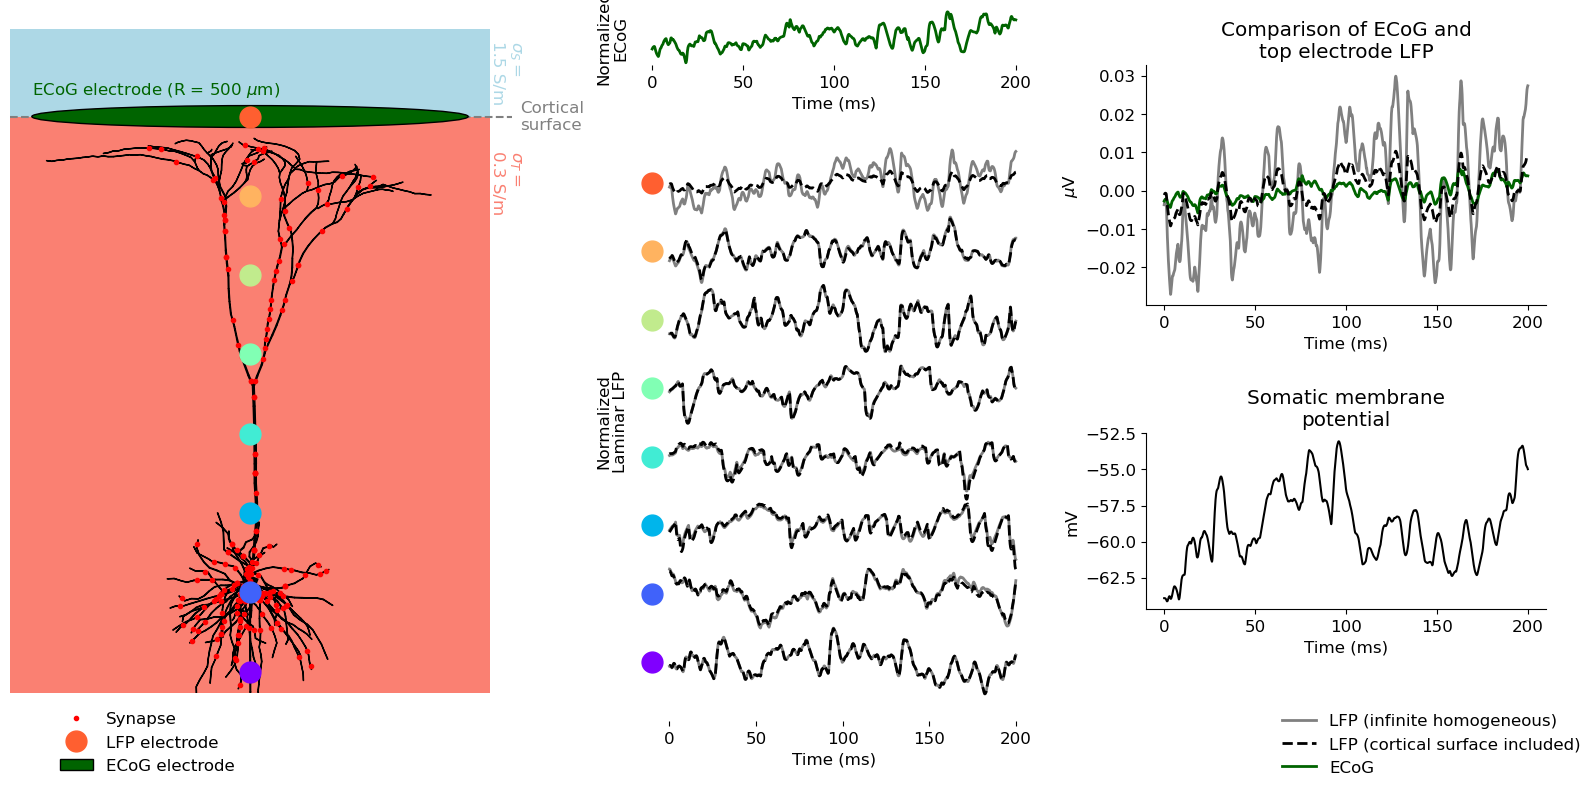

In [16]:

# perform NEURON simulation, results saved as attributes in the cell instance
cell.simulate(rec_imem=True)

# Initialize electrode geometry, then calculate the LFP, using the
# electrode classes. Note that now cell is given as input to electrode
# and created after the NEURON simulations are finished
electrode = LFPy.RecExtElectrode(cell, **electrodeParameters)
electrode.data = electrode.get_transformation_matrix() @ cell.imem
electrode.data -= np.average(electrode.data, axis=1)[:, None]

electrode_MoI = LFPy.RecMEAElectrode(cell, **elec_with_MoIParameters)
electrode_MoI.data = electrode_MoI.get_transformation_matrix() @ cell.imem
electrode_MoI.data -= np.average(electrode_MoI.data, axis=1)[:, None]

ecog_electrode = LFPy.RecMEAElectrode(cell, **ecogParameters)
ecog_electrode.data = ecog_electrode.get_transformation_matrix() @ cell.imem
ecog_electrode.data -= np.average(ecog_electrode.data, axis=1)[:, None]

# plotting some variables and geometry, saving output to .pdf.
fig = plot_LFP_and_ECoG(cell, electrode, electrode_MoI, ecog_electrode)
fig.savefig('example_ECoG.pdf', dpi=300)
plt.show()